In [58]:
# Импорт необходимых библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import requests
from urllib.parse import urlencode
import pingouin as pg
import scipy.stats as ss

%matplotlib inline

# Задание 1

Retention – один из ключевых показателей в компании. Вам необходимо разработать функцию, рассчитывающую удержание игроков (по дням с момента их регистрации).

In [59]:
# загружаем данные
reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [60]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [61]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [62]:
# проверяем на отсутсвие нулевых значений и смотрим типы данных
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [63]:
# таже проверяем, что в регистрациях все айди уникальные
reg.uid.nunique()

1000000

In [64]:
# проверяем на отсутсвие нулевых значений и смотрим типы данных
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [65]:
# мероджим данные в один датафрейм
reg_auth = auth.merge(reg, on='uid')

In [66]:
# проверяем, что все на месте
reg_auth.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


In [67]:
# Переводим столбки с датой в формат даты
reg_auth['auth_ts'] = reg_auth['auth_ts'].apply(lambda x: datetime.fromtimestamp(x))
reg_auth['reg_ts'] = reg_auth['reg_ts'].apply(lambda x: datetime.fromtimestamp(x))

In [68]:
# проверяем 
reg_auth.head()

,auth_ts,uid,reg_ts
0,1998-11-18 12:43:43,1,1998-11-18 12:43:43
1,1999-07-23 02:38:09,2,1999-07-23 02:38:09
2,1999-07-25 20:46:46,2,1999-07-23 02:38:09
3,1999-07-31 07:50:15,2,1999-07-23 02:38:09
4,1999-08-05 21:49:39,2,1999-07-23 02:38:09


In [69]:
# смотрим минимальную 
reg_auth.auth_ts.min()

Timestamp('1998-11-18 12:43:43')

In [70]:
# и максимальную даты
reg_auth.auth_ts.max()

Timestamp('2020-09-23 18:17:24')

Попробуем просчитать Retention в имеющемся датафрейме, чтобы затем написать функцию из этого хода решения. Для этого нам надо првоести когортный анализ

In [71]:
# создаем колонки с днем регистрации и днем авторизации, так как нам нужен retention по дням
reg_auth['reg_day'] = reg_auth.reg_ts.dt.to_period('D')
reg_auth['auth_day'] = reg_auth.auth_ts.dt.to_period('D')

In [72]:
reg_auth.head()

,auth_ts,uid,reg_ts,reg_day,auth_day
0,1998-11-18 12:43:43,1,1998-11-18 12:43:43,1998-11-18,1998-11-18
1,1999-07-23 02:38:09,2,1999-07-23 02:38:09,1999-07-23,1999-07-23
2,1999-07-25 20:46:46,2,1999-07-23 02:38:09,1999-07-23,1999-07-25
3,1999-07-31 07:50:15,2,1999-07-23 02:38:09,1999-07-23,1999-07-31
4,1999-08-05 21:49:39,2,1999-07-23 02:38:09,1999-07-23,1999-08-05


In [73]:
# Возьмем, например регистрации за предпоследнюю неделю в данных и период расчета retention 
# также возьмем 7 дней
reg_auth.query('"2020-09-10" <= reg_day <= "2020-09-16"')

,auth_ts,uid,reg_ts,reg_day,auth_day
9571916,2020-09-10 00:00:37,1085739,2020-09-10 00:00:37,2020-09-10,2020-09-10
9571917,2020-09-10 00:01:31,1085740,2020-09-10 00:01:31,2020-09-10,2020-09-10
9571918,2020-09-10 00:02:25,1085741,2020-09-10 00:02:25,2020-09-10,2020-09-10
9571919,2020-09-10 00:03:18,1085742,2020-09-10 00:03:18,2020-09-10,2020-09-10
9571920,2020-09-10 00:04:12,1085744,2020-09-10 00:04:12,2020-09-10,2020-09-10
...,...,...,...,...,...
9588668,2020-09-16 23:56:12,1098301,2020-09-16 23:56:12,2020-09-16,2020-09-16
9588669,2020-09-16 23:57:05,1098302,2020-09-16 23:57:05,2020-09-16,2020-09-16
9588670,2020-09-16 23:57:58,1098303,2020-09-16 23:57:58,2020-09-16,2020-09-16
9588671,2020-09-16 23:58:51,1098304,2020-09-16 23:58:51,2020-09-16,2020-09-16


In [74]:
# Фильтруем нужные даты регистрации
reg_auth_part = reg_auth.query('"2020-09-10" <= reg_day <= "2020-09-16"')

In [75]:
# Группируем по дате регистрации и авторизации
# и считаем уникальных пользователей
cohorts = reg_auth_part.groupby(['reg_day', 'auth_day'], as_index=False) \
              .agg({'uid' : 'nunique'})
cohorts.head()

,reg_day,auth_day,uid
0,2020-09-10,2020-09-10,1609
1,2020-09-10,2020-09-11,29
2,2020-09-10,2020-09-12,71
3,2020-09-10,2020-09-13,74
4,2020-09-10,2020-09-14,70


In [76]:
# Добавляем столбик с количеством дней между авторизациями для нашего когортного анализа
cohorts['days'] = cohorts.auth_day.dt.day - cohorts.reg_day.dt.day
cohorts = cohorts.query('days <= 7')
cohorts.head()

,reg_day,auth_day,uid,days
0,2020-09-10,2020-09-10,1609,0
1,2020-09-10,2020-09-11,29,1
2,2020-09-10,2020-09-12,71,2
3,2020-09-10,2020-09-13,74,3
4,2020-09-10,2020-09-14,70,4


In [77]:
# Делаем сводную таблицу по дням для визуализации когорт
cohorts = cohorts.pivot(index='reg_day', columns='days', values='uid')
cohorts

days,0,1,2,3,4,5,6,7
reg_day,,,,,,,,
2020-09-10,1609,29,71,74,70,112,93,110
2020-09-11,1611,23,64,63,99,102,111,101
2020-09-12,1614,29,66,64,65,102,111,93
2020-09-13,1617,36,72,64,81,100,107,84
2020-09-14,1620,32,63,69,94,102,111,111
2020-09-15,1622,37,65,73,98,93,113,87
2020-09-16,1625,34,67,72,81,99,125,65


In [78]:
# Переведем данные в доли и уберем первый столбик, так как в день регистрации
# все пользоватили, очевидно, и авторизовывались
cohorts = cohorts.divide(cohorts.iloc[:,0], axis = 0)
cohorts = cohorts.drop(0, axis=1)
cohorts

days,1,2,3,4,5,6,7
reg_day,,,,,,,
2020-09-10,0.018024,0.044127,0.045991,0.043505,0.069608,0.057800,0.068365
2020-09-11,0.014277,0.039727,0.039106,0.061453,0.063315,0.068901,0.062694
2020-09-12,0.017968,0.040892,0.039653,0.040273,0.063197,0.068773,0.057621
2020-09-13,0.022263,0.044527,0.039579,0.050093,0.061843,0.066172,0.051948
2020-09-14,0.019753,0.038889,0.042593,0.058025,0.062963,0.068519,0.068519
2020-09-15,0.022811,0.040074,0.045006,0.060419,0.057337,0.069667,0.053637
2020-09-16,0.020923,0.041231,0.044308,0.049846,0.060923,0.076923,0.040000


In [79]:
# Стилизуем покащатели retention для наглядности
ur_style = (cohorts
            .style
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

days,1,2,3,4,5,6,7
reg_day,,,,,,,
2020-09-10,1.80%,4.41%,4.60%,4.35%,6.96%,5.78%,6.84%
2020-09-11,1.43%,3.97%,3.91%,6.15%,6.33%,6.89%,6.27%
2020-09-12,1.80%,4.09%,3.97%,4.03%,6.32%,6.88%,5.76%
2020-09-13,2.23%,4.45%,3.96%,5.01%,6.18%,6.62%,5.19%
2020-09-14,1.98%,3.89%,4.26%,5.80%,6.30%,6.85%,6.85%
2020-09-15,2.28%,4.01%,4.50%,6.04%,5.73%,6.97%,5.36%
2020-09-16,2.09%,4.12%,4.43%,4.98%,6.09%,7.69%,4.00%


Таким образом нам удалось составить таблицу c retention пользователей по дням от различных дат регистрации в диапозоне. Попробуем записать наше решение выше в виде функции

В качестве вводных данных нам нужны два датасэта, диапазон дат регистраций (2 крайних даты диапозона) и срок расчета retention

### Ответ на задание 1

In [80]:
def retention (reg_data, auth_data, first_day, last_day, period):
    
    # объединение данных и формирование с колонками дат по дням
    reg_auth = auth_data.merge(reg_data, on='uid')
    reg_auth['auth_ts'] = reg_auth['auth_ts'].apply(lambda x: datetime.fromtimestamp(x))
    reg_auth['reg_ts'] = reg_auth['reg_ts'].apply(lambda x: datetime.fromtimestamp(x))
    reg_auth['reg_day'] = reg_auth.reg_ts.dt.to_period('D')
    reg_auth['auth_day'] = reg_auth.auth_ts.dt.to_period('D')
    
    # фильтрация регистраций в заданном периоде
    reg_auth_part = reg_auth[(reg_auth['reg_day'] >= first_day) & (reg_auth['reg_day'] <= last_day)]
    
    
    # формирование когорт и расчет retention в процентах
    cohorts = reg_auth_part.groupby(['reg_day', 'auth_day'], as_index=False) \
              .agg({'uid' : 'nunique'})
    cohorts['days'] = cohorts.auth_day.dt.day - cohorts.reg_day.dt.day
    cohorts = cohorts[(cohorts['days'] <= period)]
    
    cohorts = cohorts.pivot(index='reg_day', columns='days', values='uid')
    cohorts = cohorts.divide(cohorts.iloc[:,0], axis = 0)
    cohorts = cohorts.drop(0, axis=1)
    
    # визуализация retention по когортам с heatmap
    ur_style = (cohorts
            .style
            .background_gradient(cmap='viridis')
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
    return ur_style

Проверяем на разных участках данных

In [81]:
retention(reg, auth, '2020-09-10', '2020-09-16', 7)

days,1,2,3,4,5,6,7
reg_day,,,,,,,
2020-09-10,1.80%,4.41%,4.60%,4.35%,6.96%,5.78%,6.84%
2020-09-11,1.43%,3.97%,3.91%,6.15%,6.33%,6.89%,6.27%
2020-09-12,1.80%,4.09%,3.97%,4.03%,6.32%,6.88%,5.76%
2020-09-13,2.23%,4.45%,3.96%,5.01%,6.18%,6.62%,5.19%
2020-09-14,1.98%,3.89%,4.26%,5.80%,6.30%,6.85%,6.85%
2020-09-15,2.28%,4.01%,4.50%,6.04%,5.73%,6.97%,5.36%
2020-09-16,2.09%,4.12%,4.43%,4.98%,6.09%,7.69%,4.00%


In [82]:
retention(reg, auth, '2020-09-17', '2020-09-23', 7)

days,1,2,3,4,5,6
reg_day,,,,,,
2020-09-17,1.66%,4.12%,4.36%,5.90%,6.21%,5.53%
2020-09-18,2.15%,4.23%,4.54%,4.66%,4.48%,
2020-09-19,1.84%,3.61%,4.72%,4.10%,,
2020-09-20,2.32%,4.34%,3.48%,,,
2020-09-21,1.77%,3.24%,,,,
2020-09-22,1.34%,,,,,
2020-09-23,,,,,,


In [83]:
retention(reg, auth, '2020-09-01', '2020-09-08', 12)

days,1,2,3,4,5,6,7,8,9,10,11,12
reg_day,,,,,,,,,,,,
2020-09-01,2.08%,4.48%,3.79%,5.11%,5.93%,5.93%,6.12%,4.79%,4.92%,5.74%,4.92%,4.79%
2020-09-02,2.08%,4.28%,4.16%,6.17%,6.11%,6.80%,6.11%,5.16%,3.78%,5.54%,5.92%,5.35%
2020-09-03,2.39%,5.09%,5.09%,6.22%,6.79%,8.49%,6.16%,5.15%,6.41%,6.54%,5.59%,5.41%
2020-09-04,1.88%,3.89%,4.96%,4.83%,6.78%,7.16%,4.96%,4.96%,4.65%,5.90%,4.90%,4.96%
2020-09-05,2.13%,4.14%,4.39%,4.95%,6.58%,7.14%,5.26%,5.20%,5.33%,6.14%,4.89%,4.70%
2020-09-06,3.50%,4.32%,5.13%,5.82%,5.82%,6.95%,6.45%,5.63%,5.57%,5.51%,5.57%,4.63%
2020-09-07,2.75%,4.12%,5.50%,5.00%,6.68%,6.37%,5.75%,4.18%,4.68%,5.62%,6.00%,5.12%
2020-09-08,1.93%,3.55%,3.43%,5.86%,7.04%,7.23%,6.67%,4.99%,5.61%,6.23%,5.61%,5.24%


# Задание 2

Проведен A/B-тест, в котором пользователям предлагались разные варианты акционных предложений. Установлено, что ARPU в тестовой группе выше на 5% по сравнению с контрольной.

При этом:

В контрольной группе 1928 из 202103 пользователей совершили покупки.\
В тестовой группе 1805 из 202667 игроков стали платящими.\
Вопросы для анализа:

Какой из вариантов предложений является наиболее эффективным?\
Какие метрики следует рассмотреть для корректного вывода?\
Каким образом провести анализ?

In [84]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_df = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'
 
# получаем url 
final_url_df = base_url + urlencode(dict(public_key=public_key_df)) 
response_df = requests.get(final_url_df) 
download_url_df = response_df.json()['href']

# загружаем файлы в df 
download_response_df = requests.get(download_url_df) 
df = pd.read_csv(download_url_df, sep=';') 

In [86]:
# смотрим
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [87]:
# проверяем что нет нулевых значений и смотрим инфо
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [88]:
# проверяем уникальные ли все юзеры
df.user_id.nunique()

404770

In [89]:
# проверяем, что количество пользователей в группах распределено, как указано в задании
df.groupby(['testgroup'], as_index=False).agg({'user_id' : 'nunique'})

,testgroup,user_id
0,a,202103
1,b,202667


Мы можем статистически проанализировать три метрики в этих данных и сравнить их между группами статистически

1. ARPU
2. ARPPU
3. Конверсия

## ARPU

Cредний доход с привлечённого пользователя. Это то, что уже указано в наших данных в столбике revenue

### Визуализация

In [90]:
# посмотрим описательные стистики по выручке
df.query('testgroup == "a"').revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [91]:
df.query('testgroup == "b"').revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

Максимальные значения и стандартные отклонения сильно разнятся по выборкам, в контрольной группе более серьезные выбросы

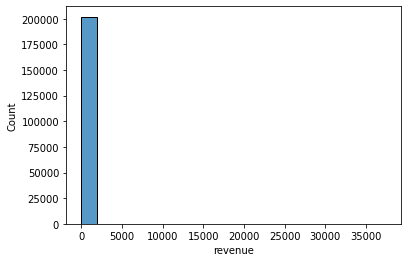

In [92]:
# и гистограммы
sns.histplot(data=df.query('testgroup == "a"').revenue)

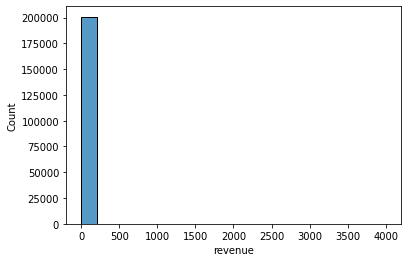

In [93]:
sns.histplot(data=df.query('testgroup == "b"').revenue)

На гистограмме не видно самих выбросов, так как их мало на выборку, но по ширине оси Х это тоже можно пронаблюдать

Не знаю, что лучше сделать с этими выбросами, может стоили выбросить их из данных, но тогда это очень сильно повлияет на конверсию и анализ будет неактуальным. Для ARPU и ARPPU, наверное, можно было бы убрать выбросы из обеих выборок, но все же я все еще не уверен, что это хорошая идея. Но и делать выводы по таким раскошенным данным тоже может быть не лучшей идеей. Но проведем анализ по ним

Для ARPU & ARPPU мы можем использовать Т-тест, а для конверсии Хи-квадрат

### Проверка на нормальность

In [94]:
pg.normality(df.query('testgroup == "a"').revenue, method='normaltest')

,W,pval,normal
revenue,585152.731273,0.0,False


In [95]:
pg.normality(df.query('testgroup == "b"').revenue, method='normaltest')

,W,pval,normal
revenue,326622.395409,0.0,False


В обеих выборках мы отвергаем нулевую гипотезу о нормальности распределения количества просмотренных анкет, так как p-value ниже порога 0.05, но все равно можем использовать Т-тест, так как выборки очень большие

### Проверка дисперсий на гомогенность

In [96]:
ss.levene(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Значение p-value выше 0,05, что позволяет принять нулевую гипотезу о равенстве дисперсий в выборках

### Расчет результатов по ARPU

Для Т-критерия Стъюдента
- $H_0$: предполагает, что средние равны
- $H_1$: отвергает нулевую гипотезу о равенстве средних

In [97]:
pg.ttest(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


В нашем случае p-value равняется 0.53, что значит, что мы принимаем $H_0$ о равенстве средних значений по ARPU в выборках

## ARPPU

Средний доход на платящего пользователя (то есть клиента).

In [98]:
# для этого отфильтруем из данных только платящих юзеров
arppu_df = df.query('revenue > 0')

### Визуализация

In [99]:
arppu_df.query('testgroup == "a"').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [100]:
arppu_df.query('testgroup == "b"').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

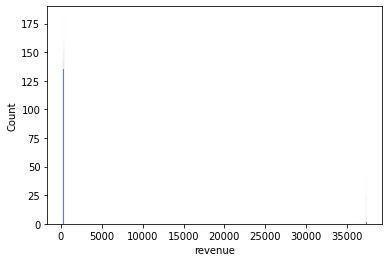

In [101]:
sns.histplot(data=arppu_df.query('testgroup == "a"').revenue)

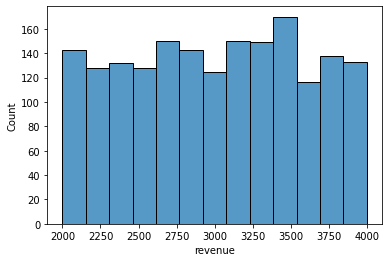

In [102]:
sns.histplot(data=arppu_df.query('testgroup == "b"').revenue)

Здесь мы еще более явно видим выбросы в первой выборке и теперь даже понятно, что совсем экстремальные значения находятся только в контрольной группе, а в тестовой суммы чеков распределены равномерно

### Проверка на нормальность

In [103]:
pg.normality(arppu_df.query('testgroup == "a"').revenue, method='normaltest')

,W,pval,normal
revenue,1394.945784,1.234161e-303,False


In [104]:
pg.normality(arppu_df.query('testgroup == "b"').revenue, method='normaltest')

,W,pval,normal
revenue,1068.860008,7.943249e-233,False


В обеих выборках мы отвергаем нулевую гипотезу о нормальности распределения количества просмотренных анкет, так как p-value ниже порога 0.05, но все равно можем использовать Т-тест, так как выборки очень большие

### Проверка дисперсий на гомогенность

In [105]:
ss.levene(arppu_df.query('testgroup == "a"').revenue, arppu_df.query('testgroup == "b"').revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Значение p-value нижу 0,05, а значит гипотеза о гомогенности дисперсий отвергается, и нам нужно применить Т-тест с критерием Уэлча

### Расчет результатов по ARPPU

Для Т-критерия Стъюдента
- $H_0$: предполагает, что средние равны
- $H_1$: отвергает нулевую гипотезу о равенстве средних

In [106]:
pg.ttest(arppu_df.query('testgroup == "a"').revenue, arppu_df.query('testgroup == "b"').revenue, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


В нашем случае p-value равняется 0.1, что значит, что мы принимаем $H_0$ о равенстве средних значений по ARPU в выборках

## Конверсия

In [107]:
# создаем столбик, где отметим произвел ли юзер покупку
df['converted'] = df['revenue'] > 0
df.head()

,user_id,revenue,testgroup,converted
0,1,0,b,False
1,2,0,a,False
2,3,0,a,False
3,4,0,b,False
4,5,0,b,False


In [108]:
pd.crosstab(df.converted, df.testgroup)

testgroup,a,b
converted,,
False,200175,200862
True,1928,1805


Для критерия Хи-квадрат
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [109]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(df.converted, df.testgroup))
stat, p, expected

(4.374729521260405,
 0.03647561892312613,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

В нашем случае p-value равняется 0.036, что ниже 0.05 и значит, что мы отклоняем $H_0$ и принимаем альтернативную $H_1$ о том, что взаимосвязь есть

Люди в контрольной группе чаще совершают покупку, но наши данные по группам все также перекошены

### Ответ на задание 2 - Выводы

1. По ARPU & ARPPU нет значимых различий между группами
2. Конверсия выше в контрольной группе, но данные по покупкам в группах перекошены с выбросами в контрольной групп
3. По результатам тестов логичным кажется, что набор предложений из контрольной группы лучше (может эти предложения и вызвали большие покупки? или все же что-то с данными, не знаю)

# Задание 3

В игре Plants & Gardens ежемесячно проходят временные тематические события, в которых игроки могут получать эксклюзивные предметы, персонажей, бонусные монеты и другие награды. Для получения приза необходимо пройти определенное количество уровней в установленный срок.

Анализ:

Какие метрики помогут оценить результаты последнего завершенного события?\
Как повлияет изменение механики, при котором игрок откатывается на несколько уровней назад после неудачной попытки? Нужно ли пересматривать набор метрик?

### Первый вопрос

Основные метрики, которые можно посмотреть для оценки результатов я бы подразделил на 2 вида метрик:\
1. Метрики участия и вовлеченности игроков
2. Метрики экономики

### Метрики участия и вовлеченности игроков

1. DAU - метрика, которая отражает количество активных пользователей приложения за один день. Можно посмотреть больше ли пользовталей заходит в игру 
2. Количество игровых сессий во время события. Заходят ли пользователи чаще в игру во время событий
3. Среднее время пользователей за одну сессию. Проводят ли игроки больше времени в игре во время событий
4. Retention игроков, участвующих в событии (вернулись ли они в игру на следующий день, через неделю и т.д.)
5. Количество игроков, учаcтвующих в событии и их доля от общего количество играющих во время этого события
6. Количество и доля игроков, успешно прошедших событие

### Метрики экономики

1. ARPU и ARPPU. Покупают ли пользователи чаще внутриигровую валюту и улучшения за реальные деньги, чтобы успевать пройти события и получить все награды
2. Conversion. Растет ли доля пользователей, которые совершают покупки во время события, чтобы получить уникальные награды

Помимо этих основных метрик также можно следить и за метриками внутренней экономики игры и анализировать то, как обращаются игроки с внутриигровой валютой: тратят ли больше внутриигровой валюты и различных бустов во время события, а также метрики самого события: количество пройденных уровней, время потраченное на их прохождение, как одного конкретного уровня, так и всего события целиком

### Второй вопрос

В данном случае механика события усложнена, что добавляет необходимость пронаблюдать и другие метрики, которые позволят оценить эффект от влияния изменения механики

### Метрики участия и вовлеченности игроков

1. При такой механике событий можно дополнительно посмотреть на Churn rate - метрику оттока клиентов, чтобы посмотреть приводят ли откатывания назад к тому, что пользователи выходят из игры
2. Также в оттоке клиентов важно отдельно просмотреть именно тех игроков, которые отказлись от прохождения события после отката
3. При такой механике событий также может быть важным получить обратную связь от игроков об этой механике, дав написать отзыв или возможность оценить событие, и тогда метрикой будет рейтинг события у игроков
4. Также важным останется отследить количество игроков, кто сможет пройти событие при такой механике

### Метрики экономики

Здесь также останутся актуальными метрики, указанные выше и за ними стоит проследить, оценив эффект влияния изменения механики на них. Возможно, игроки будут активнее покупать улучшения и валюту, чтобы пройти событие с более сложной механикой, особенно если награды за это события будут более ценными либо же они, наоборот, будут менее активно тратить деньги из-за дополнительных сложностей при прихождении события

Механика с откатом повышает сложность события и может вызывать большее напряжение у игроков. Это может:

1. Увеличить\уменьшить монетизацию за счет покупки усилений. (поэтому анализ метрик экономики все также важен)
2. Снизить удовлетворенность и вовлеченность, если игроки воспримут усложнение как несправедливое, а задачу прохождения события тяжеловыполнимой.
3. Повлиять на количество завершивших событие, так как усложненные механики часто отсекают менее опытных игроков: доля завершивих события окажется небольшой, а отток клиентов из события будет высоким.